In [2]:
from scqbf import *
from scqbf.solvers import *

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from concurrent.futures import ProcessPoolExecutor, as_completed

## Running all 15 instances on each of the 4 solvers and collecting results

Implemented using multiprocessing to parallelize the runs. Once each instance is processed by all solvers, the results are serialized to a pickle file for later analysis. This also allows resuming from where it left off in case of interruptions.

In [2]:
pickle_dir = Path("pickles/pprofile")
pickle_dir.mkdir(parents=True, exist_ok=True)

def process_instance(path, i, j):
    """Process a single instance and save results to pickle."""
    pickle_path = pickle_dir / f"gen{i}_instance{j}.pkl"
    
    if pickle_path.exists():
        return f"Skipping gen{i}/instance{j} - results already exist"
    
    print(f"Processing gen{i}/instance{j}...")
    instance = ScQbfInstance.from_file(path)
    
    termination_criteria = TerminationCriteria(max_time_secs=30*60)  # 30 minutes per instance
    gurobi_solver: ScQbfGurobi = ScQbfGurobi(instance, termination_criteria=termination_criteria)
    results = {}
    
    # First, solve Gurobi; if optimal is found, update termination criteria:
    # No reason to keep heuristics running longer than optimal found by Gurobi
    gurobi_solver.solve()
    results[gurobi_solver.__class__.__name__] = {
        "result": gurobi_solver.best_solution,
        "time": gurobi_solver.execution_time,
    }
    if gurobi_solver.absolute_gap == 0:
        termination_criteria.target_value = gurobi_solver.best_solution.objfun_val

    heuristics: list[SCQBF_Solver] = [
        ScQbfGrasp(instance, termination_criteria=termination_criteria),
        ScQbfTS(instance, termination_criteria=termination_criteria),
        ScQbfGA(instance, termination_criteria=termination_criteria),
    ]

    for solver in heuristics:
        result = solver.solve()
        results[solver.__class__.__name__] = {
            "result": result,
            "time": solver.execution_time,
        }

    with open(pickle_path, 'wb') as f:
        pickle.dump(results, f)
    return f"Saved results for gen{i}/instance{j}"

In [ ]:
instance_paths = [(f"instances/gen{i}/instance{j}.txt", i, j) for i in range(1, 4) for j in range(1, 6)]

with ProcessPoolExecutor(max_workers=6) as executor:
    futures = {executor.submit(process_instance, path, i, j): (i, j) for path, i, j in instance_paths}
    
    for future in as_completed(futures):
        i, j = futures[future]
        try:
            result = future.result()
            print(result)
        except Exception as exc:
            print(f"gen{i}/instance{j} generated an exception: {exc}")

Processing gen1/instance3...Processing gen1/instance2...Processing gen1/instance4...Processing gen1/instance1...



Set parameter Username
Set parameter LicenseID to value 2694661
Academic license - for non-commercial use only - expires 2026-08-09
Set parameter Username
Set parameter LicenseID to value 2694661
Academic license - for non-commercial use only - expires 2026-08-09
Set parameter Username
Set parameter LicenseID to value 2694661
Set parameter Username
Set parameter LicenseID to value 2694661
Academic license - for non-commercial use only - expires 2026-08-09
Academic license - for non-commercial use only - expires 2026-08-09
containing a solution
Processing gen1/instance5...
Saved results for gen1/instance4
containing a solution
containing a solution
containing a solution
Processing gen2/instance1...
Saved results for gen1/instance3
containing a solution
Processing gen2/instance2...
Saved results for gen1/instance5
Processing gen2/instance3...
Saved results for gen1/instance

In [3]:
# Load all pickled results and combine into a dataframe

pickle_dir = Path("pickles/pprofile")
all_results = []

for pickle_file in sorted(pickle_dir.glob("gen*_instance*.pkl")):
    filename = pickle_file.stem

    with open(pickle_file, 'rb') as f:
        results = pickle.load(f)
    
    for solver_name, solver_data in results.items():
        all_results.append({
            "solver": solver_name.replace("ScQbf", ""),
            "instance": filename,
            "objfun_val": solver_data["result"].objfun_val,
            "time": solver_data["time"]
        })

df = pd.DataFrame(all_results)
display(df.sort_values(["instance", "solver"]))

,solver,instance,objfun_val,time
3,GA,gen1_instance1,4611.47,5804.004103
1,Grasp,gen1_instance1,4614.25,1809.562207
0,Gurobi,gen1_instance1,4340.36,1804.903431
2,TS,gen1_instance1,4305.79,1800.187903
7,GA,gen1_instance2,4668.07,2422.403329
5,Grasp,gen1_instance2,4668.07,1808.751533
4,Gurobi,gen1_instance2,4508.92,1805.076142
6,TS,gen1_instance2,4611.62,1800.398173
11,GA,gen1_instance3,645.62,0.726855
9,Grasp,gen1_instance3,645.62,14.268118


## Analyzing results and plotting performance profiles

### Calculating performance ratios

In [4]:
best_obj_per_instance = df.groupby('instance')['objfun_val'].max()

# Calculate performance ratio for each solver on each instance
# For maximization: ratio = best_value / solver_value (≥ 1, lower is better)
df['performance_ratio'] = df.apply(
    lambda row: best_obj_per_instance[row['instance']] / row['objfun_val'] if row['objfun_val'] > 0 else np.inf,
    axis=1
)

display(df.sort_values(['instance', 'solver']))

,solver,instance,objfun_val,time,performance_ratio
3,GA,gen1_instance1,4611.47,5804.004103,1.000603
1,Grasp,gen1_instance1,4614.25,1809.562207,1.000000
0,Gurobi,gen1_instance1,4340.36,1804.903431,1.063103
2,TS,gen1_instance1,4305.79,1800.187903,1.071638
7,GA,gen1_instance2,4668.07,2422.403329,1.000000
5,Grasp,gen1_instance2,4668.07,1808.751533,1.000000
4,Gurobi,gen1_instance2,4508.92,1805.076142,1.035297
6,TS,gen1_instance2,4611.62,1800.398173,1.012241
11,GA,gen1_instance3,645.62,0.726855,1.000000
9,Grasp,gen1_instance3,645.62,14.268118,1.000000


### Plotting performance profiles

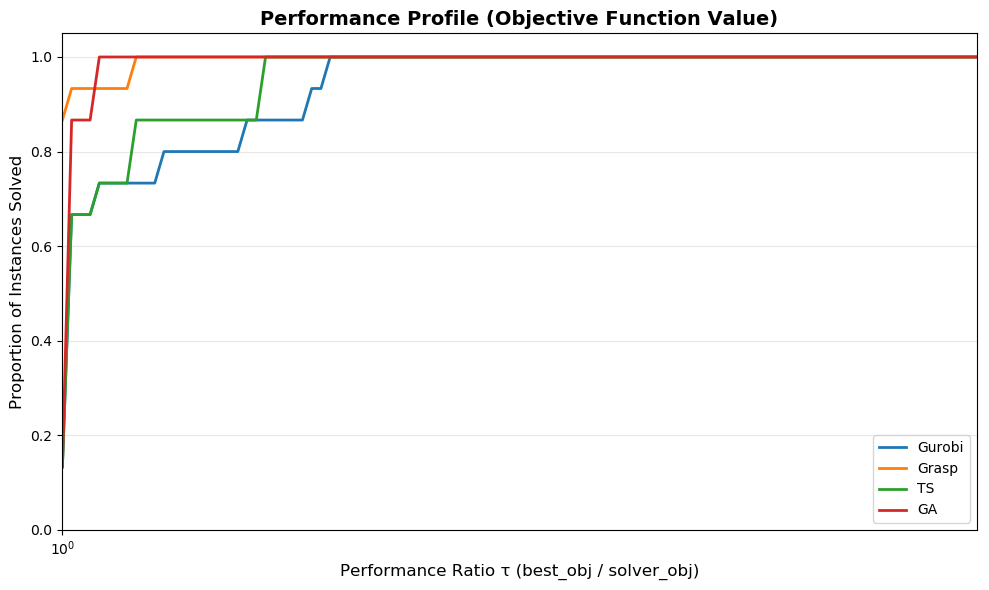

In [5]:
solvers = df['solver'].unique()
tau_values = np.logspace(0, np.log10(df['performance_ratio'].max()*1.25), 100)

plt.figure(figsize=(10, 6))

for solver in solvers:
    solver_ratios = df[df['solver'] == solver]['performance_ratio'].values
    
    # Calculate cumulative distribution: proportion of instances where ratio <= tau
    rho_tau = []
    for tau in tau_values:
        proportion = np.sum(solver_ratios <= tau) / len(solver_ratios)
        rho_tau.append(proportion)
    
    plt.plot(tau_values, rho_tau, label=solver, linewidth=2)

plt.xlabel('Performance Ratio τ (best_obj / solver_obj)', fontsize=12)
plt.ylabel('Proportion of Instances Solved', fontsize=12)
plt.title('Performance Profile (Objective Function Value)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)
plt.xlim(1, tau_values[-1])
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [6]:
# Display performance statistics
print("\nPerformance Statistics:")
print("-" * 60)
for solver in solvers:
    solver_data = df[df['solver'] == solver]
    ratios = solver_data['performance_ratio'].values
    
    print(f"\n{solver}:")
    print(f"  Best solutions found: {np.sum(ratios == 1)} / {len(ratios)}")
    print(f"  Average performance ratio: {ratios.mean():.4f}")
    print(f"  Median performance ratio: {np.median(ratios):.4f}")
    print(f"  Worst performance ratio: {ratios.max():.4f}")


Performance Statistics:
------------------------------------------------------------

Gurobi:
  Best solutions found: 2 / 15
  Average performance ratio: 1.0195
  Median performance ratio: 1.0000
  Worst performance ratio: 1.0940

Grasp:
  Best solutions found: 13 / 15
  Average performance ratio: 1.0016
  Median performance ratio: 1.0000
  Worst performance ratio: 1.0237

TS:
  Best solutions found: 2 / 15
  Average performance ratio: 1.0137
  Median performance ratio: 1.0000
  Worst performance ratio: 1.0716

GA:
  Best solutions found: 2 / 15
  Average performance ratio: 1.0014
  Median performance ratio: 1.0000
  Worst performance ratio: 1.0107
